In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/beyond-visible-spectrum-ai-for-agriculture-2026p2.zip

Streaming output truncated to the last 5000 lines.
  inflating: archive/share/val/1215/B11.tif  
  inflating: archive/share/val/1215/B12.tif  
  inflating: archive/share/val/1215/B2.tif  
  inflating: archive/share/val/1215/B3.tif  
  inflating: archive/share/val/1215/B4.tif  
  inflating: archive/share/val/1215/B5.tif  
  inflating: archive/share/val/1215/B6.tif  
  inflating: archive/share/val/1215/B7.tif  
  inflating: archive/share/val/1215/B8.tif  
  inflating: archive/share/val/1215/B8A.tif  
  inflating: archive/share/val/1215/B9.tif  
  inflating: archive/share/val/1217/B1.tif  
  inflating: archive/share/val/1217/B11.tif  
  inflating: archive/share/val/1217/B12.tif  
  inflating: archive/share/val/1217/B2.tif  
  inflating: archive/share/val/1217/B3.tif  
  inflating: archive/share/val/1217/B4.tif  
  inflating: archive/share/val/1217/B5.tif  
  inflating: archive/share/val/1217/B6.tif  
  inflating: archive/share/val/1217/B7.tif  
  inflating: archive/share/val/1217/B8.tif  

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import tifffile as tiff
from tqdm import tqdm
import os

In [ ]:
import os
import glob
import tifffile as tiff
import numpy as np
labeled_samples = glob.glob('/content/ICPR02/kaggle/**/B2.tif', recursive=True)
unlabeled_samples = glob.glob('/content/archive/share/train/**/B2.tif', recursive=True)
def analyze_sample(file_path, title="Sample"):
    folder = os.path.dirname(file_path)
    print(f"--- {title} Analysis ---")
    print(f"Folder: {folder}")
    for b_name in ['B2', 'B12']:
        b_path = os.path.join(folder, f"{b_name}.tif")
        if os.path.exists(b_path):
            data = tiff.imread(b_path)
            print(f"  {b_name}: Shape={data.shape}, Dtype={data.dtype}, Range=[{data.min()}, {data.max()}]")
        else:
            print(f"  {b_name}: NOT FOUND in this folder.")
if labeled_samples:
    analyze_sample(labeled_samples[0], "Labeled")
else:
    print("No labeled B2.tif found. Check path: /content/ICPR02/kaggle")
print("\n")
if unlabeled_samples:
    analyze_sample(unlabeled_samples[0], "Unlabeled")
else:
    print("No unlabeled B2.tif found. Check path: /content/archive/share/train")

--- Labeled Analysis ---
Folder: /content/ICPR02/kaggle/evaluation/e0e8b341a8da414e854c4062eb8b8ea5
  B2: Shape=(264, 264), Dtype=uint16, Range=[222, 11640]
  B12: Shape=(132, 132), Dtype=uint16, Range=[438, 8489]


--- Unlabeled Analysis ---
Folder: /content/archive/share/train/maize/000449/20201129T101359_20201129T101355_T32UQV
  B2: Shape=(264, 264), Dtype=uint16, Range=[94, 2412]
  B12: Shape=(132, 132), Dtype=uint16, Range=[143, 3232]


In [ ]:
import os
import glob
import torch
import torch.multiprocessing as mp
import numpy as np
from torch.utils.data import Dataset, DataLoader
import tifffile as tiff
from torchvision import transforms
import torch.nn.functional as F
mp.set_sharing_strategy('file_system')
class SentinelSSLDataset(Dataset):
    def __init__(self, root_dirs, target_size=(224, 224)):
        self.target_size = target_size
        self.folder_paths = []
        self.bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
        for root in root_dirs:
            search_pattern = os.path.join(root, "**/B2.tif")
            found_files = glob.glob(search_pattern, recursive=True)
            self.folder_paths.extend([os.path.dirname(f) for f in found_files])
        print(f"Dataset initialized with {len(self.folder_paths)} total samples.")
    def __len__(self):
        return len(self.folder_paths)
    def __getitem__(self, idx):
        folder = self.folder_paths[idx]
        band_list = []
        for b in self.bands:
            b_path = os.path.join(folder, f"{b}.tif")
            if not os.path.exists(b_path):
                alt_b = f"B0{b[1:]}" if len(b) == 2 else b
                b_path = os.path.join(folder, f"{alt_b}.tif")
            img = tiff.imread(b_path).astype(np.float32) / 10000.0
            img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)
            img_resized = F.interpolate(img_tensor, size=self.target_size, mode='bilinear', align_corners=False)
            band_list.append(img_resized.squeeze())
        full_stack = torch.stack(band_list, dim=0)
        return full_stack
roots = ['/content/ICPR02/kaggle', '/content/archive/share/train']
ssl_dataset = SentinelSSLDataset(roots)
ssl_loader = DataLoader(ssl_dataset, batch_size=16, shuffle=True, num_workers=2)
for batch in ssl_loader:
    print(f"Batch shape: {batch.shape}")
    break

Dataset initialized with 3468 total samples.
Batch shape: torch.Size([16, 12, 224, 224])


In [ ]:
import torch
import torch.nn as nn
from timm.models.vision_transformer import Block
class MultispectralMAE(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=12,
                 embed_dim=768, depth=12, num_heads=12,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, mask_ratio=0.75):
        super().__init__()
        self.patch_embed = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)
        self.blocks = nn.ModuleList([Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer) for _ in range(depth)])
        self.norm = norm_layer(embed_dim)
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)
        self.decoder_blocks = nn.ModuleList([Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer) for _ in range(decoder_depth)])
        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True)
        self.mask_ratio = mask_ratio
        self.patch_size = patch_size
        self.in_chans = in_chans
    def random_masking(self, x, mask_ratio):
        N, L, D = x.shape
        len_keep = int(L * (1 - mask_ratio))
        noise = torch.rand(N, L, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)
        return x_masked, mask, ids_restore
    def forward(self, imgs):
        x = self.patch_embed(imgs).flatten(2).transpose(1, 2)
        x = x + self.pos_embed[:, 1:, :]
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        for blk in self.blocks: x = blk(x)
        x = self.norm(x)
        x = self.decoder_embed(x)
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))
        x = torch.cat([x[:, :1, :], x_], dim=1)
        x = x + self.decoder_pos_embed
        for blk in self.decoder_blocks: x = blk(x)
        x = self.decoder_norm(x)
        pred = self.decoder_pred(x)[:, 1:, :]
        return pred, mask
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MultispectralMAE().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1.5e-4, weight_decay=0.05)
criterion = nn.MSELoss()
print("MAE Model Initialized for 12 bands.")

MAE Model Initialized for 12 bands.


In [ ]:
import matplotlib.pyplot as plt
def visualize_mae(model, dataset, device, epoch):
    model.eval()
    with torch.no_grad():
        img = dataset[0].unsqueeze(0).to(device)
        pred, mask = model(img)
        p = model.patch_size
        h = w = img.shape[2] // p
        pred = pred.reshape(shape=(1, h, w, p, p, 12))
        pred = torch.einsum('nhwpqc->nchpwq', pred)
        reconstructed = pred.reshape(shape=(1, 12, img.shape[2], img.shape[3]))
        def to_rgb(t):
            rgb = t[0, [3, 2, 1], :, :].cpu().numpy().transpose(1, 2, 0)
            return np.clip(rgb * 3, 0, 1)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Original (RGB)")
        plt.imshow(to_rgb(img))
        plt.subplot(1, 3, 2)
        plt.title("Masked")
        plt.imshow(to_rgb(img * (1 - mask.reshape(1, 1, h, w).repeat_interleave(p, 2).repeat_interleave(p, 3))))
        plt.subplot(1, 3, 3)
        plt.title("Reconstruction")
        plt.imshow(to_rgb(reconstructed))
        plt.show()
        plt.savefig(f'reconstruction_epoch_{epoch}.png')


Epoch 1/5


Training MAE: 100%|██████████| 217/217 [01:21<00:00,  2.65it/s, loss=0.00607]


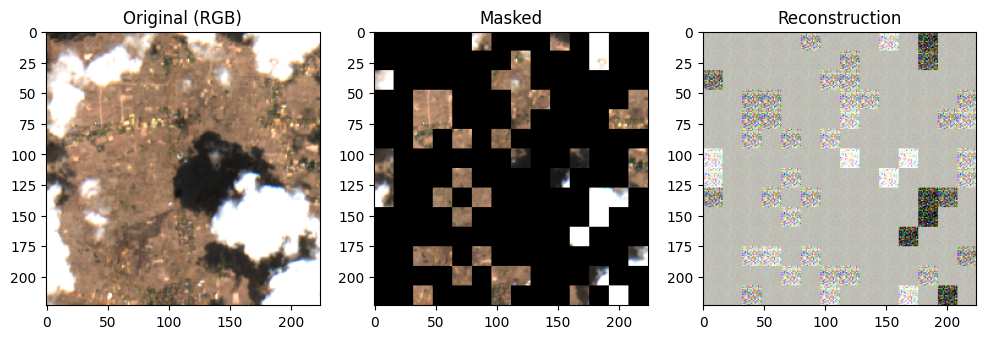


Epoch 2/5


Training MAE: 100%|██████████| 217/217 [01:21<00:00,  2.65it/s, loss=0.0244]


<Figure size 640x480 with 0 Axes>

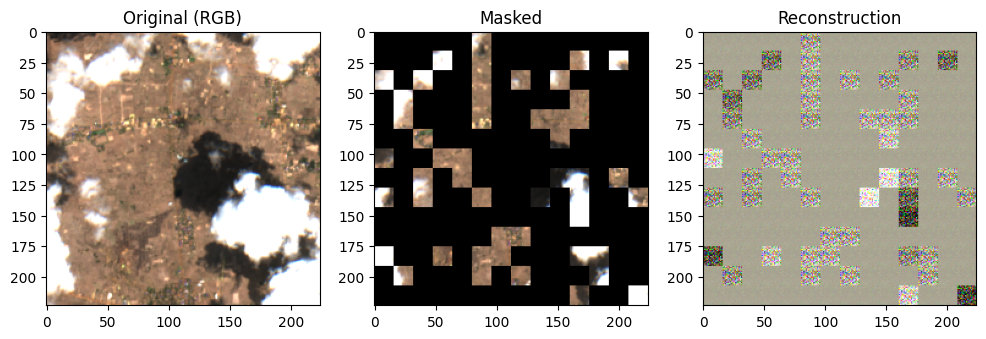


Epoch 3/5


Training MAE: 100%|██████████| 217/217 [01:22<00:00,  2.62it/s, loss=0.0194]


<Figure size 640x480 with 0 Axes>

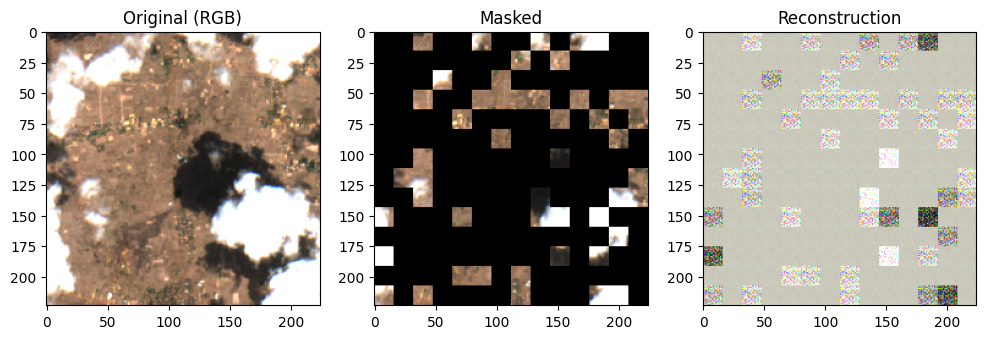


Epoch 4/5


Training MAE: 100%|██████████| 217/217 [01:22<00:00,  2.62it/s, loss=0.0216]


<Figure size 640x480 with 0 Axes>

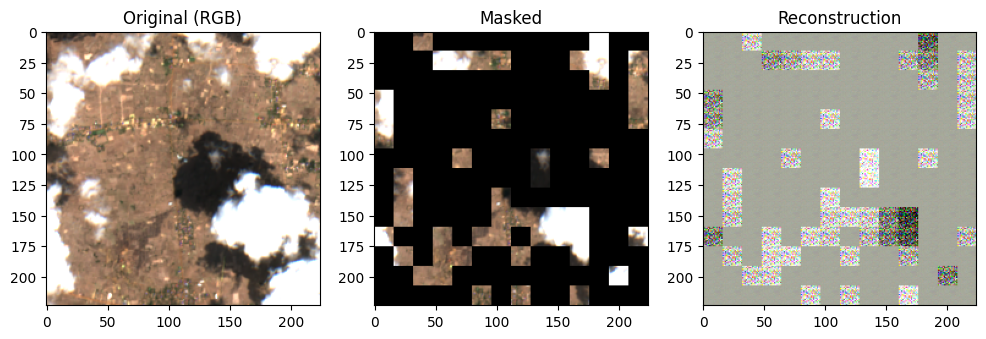


Epoch 5/5


Training MAE: 100%|██████████| 217/217 [01:23<00:00,  2.61it/s, loss=0.0198]


<Figure size 640x480 with 0 Axes>

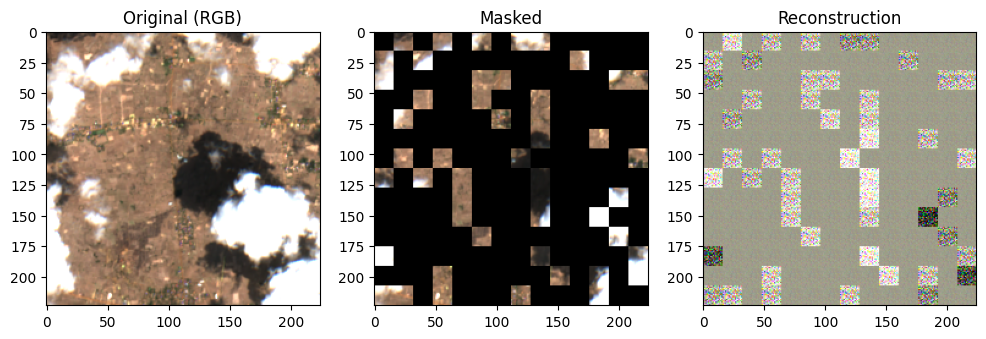

<Figure size 640x480 with 0 Axes>

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
def patchify(imgs, p=16, ch=12):
    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], ch, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * ch))
    return x
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    pbar = tqdm(loader, desc="Training MAE")
    for imgs in pbar:
        imgs = imgs.to(device, non_blocking=True)
        pred, mask = model(imgs)
        target = patchify(imgs)
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)
        loss = (loss * mask).sum() / mask.sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})
    return total_loss / len(loader)
NUM_EPOCHS = 5
best_loss = float('inf')
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    avg_loss = train_one_epoch(model, ssl_loader, optimizer, device)
    visualize_mae(model, ssl_dataset, device, epoch)
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), 'mae_multispectral_best.pth')
        torch.save(model.patch_embed.state_dict(), 'encoder_weights.pth')

In [ ]:
def save_competition_checkpoint(model, optimizer, epoch, loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'encoder_state_dict': {
            'patch_embed': model.patch_embed.state_dict(),
            'blocks': model.blocks.state_dict(),
            'norm': model.norm.state_dict(),
            'pos_embed': model.pos_embed
        },
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved: {filename}")

In [ ]:
save_competition_checkpoint(model, optimizer, 5, 0.0216, 'mae_task2_final.pth')

Checkpoint saved: mae_task2_final.pth


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import glob
import os
class DiseaseClassifier(nn.Module):
    def __init__(self, mae_model, num_classes=4):
        super().__init__()
        self.patch_embed = mae_model.patch_embed
        self.pos_embed = mae_model.pos_embed
        self.blocks = mae_model.blocks
        self.norm = mae_model.norm
        self.head = nn.Linear(768, num_classes)
    def forward(self, x):
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        x = x + self.pos_embed[:, 1:, :]
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        x = x.mean(dim=1)
        return self.head(x)
temp_mae = MultispectralMAE().to(device)
checkpoint = torch.load('mae_task2_final.pth')
temp_mae.load_state_dict(checkpoint['model_state_dict'])
classifier = DiseaseClassifier(temp_mae, num_classes=4).to(device)
for name, param in classifier.named_parameters():
    if "head" not in name:
        param.requires_grad = False
print("Classifier initialized with frozen MAE backbone.")

Classifier initialized with frozen MAE backbone.


In [ ]:
class LabeledSentinelDataset(SentinelSSLDataset):
    def __init__(self, root_dir, target_size=(224, 224)):
        self.target_size = target_size
        self.bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
        self.samples = []
        self.class_map = {'Aphid': 0, 'Blast': 1, 'RPH': 2, 'Rust': 3}
        for class_name, label in self.class_map.items():
            class_path = os.path.join(root_dir, class_name)
            folders = [f.path for f in os.scandir(class_path) if f.is_dir()]
            for f in folders:
                self.samples.append((f, label))
        print(f"Labeled Dataset: {len(self.samples)} samples found across 4 classes.")
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        folder, label = self.samples[idx]
        stack = self.load_multispectral_stack(folder)
        return stack, label
    def load_multispectral_stack(self, folder):
        band_list = []
        for b in self.bands:
            b_path = os.path.join(folder, f"{b}.tif")
            if not os.path.exists(b_path):
                b_path = os.path.join(folder, f"B0{b[1:]}.tif") if len(b)==2 else b_path
            img = tiff.imread(b_path).astype(np.float32) / 10000.0
            img_t = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)
            img_resized = F.interpolate(img_t, size=self.target_size, mode='bilinear').squeeze()
            band_list.append(img_resized)
        return torch.stack(band_list)
labeled_ds = LabeledSentinelDataset('/content/ICPR02/kaggle')
train_loader = DataLoader(labeled_ds, batch_size=32, shuffle=True, num_workers=2)

Labeled Dataset: 900 samples found across 4 classes.


In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(classifier.parameters(), lr=5e-5, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
def train_classifier(model, loader, criterion, optimizer, device, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            current_acc = 100. * correct / total
            pbar.set_postfix({'loss': running_loss/len(loader), 'acc': f"{current_acc:.2f}%"})
        print(f"Final Epoch {epoch+1} Accuracy: {current_acc:.2f}%")
train_classifier(classifier, train_loader, criterion, optimizer, device, epochs=10)

Epoch 1/10: 100%|██████████| 29/29 [00:30<00:00,  1.06s/it, loss=0.986, acc=59.33%]


Final Epoch 1 Accuracy: 59.33%


Epoch 2/10: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it, loss=0.951, acc=60.44%]


Final Epoch 2 Accuracy: 60.44%


Epoch 3/10: 100%|██████████| 29/29 [00:31<00:00,  1.08s/it, loss=0.944, acc=61.22%]


Final Epoch 3 Accuracy: 61.22%


Epoch 4/10: 100%|██████████| 29/29 [00:30<00:00,  1.06s/it, loss=0.935, acc=61.44%]


Final Epoch 4 Accuracy: 61.44%


Epoch 5/10: 100%|██████████| 29/29 [00:30<00:00,  1.06s/it, loss=0.92, acc=65.56%]


Final Epoch 5 Accuracy: 65.56%


Epoch 6/10: 100%|██████████| 29/29 [00:30<00:00,  1.06s/it, loss=0.9, acc=67.56%]


Final Epoch 6 Accuracy: 67.56%


Epoch 7/10: 100%|██████████| 29/29 [00:31<00:00,  1.08s/it, loss=0.836, acc=70.56%]


Final Epoch 7 Accuracy: 70.56%


Epoch 8/10: 100%|██████████| 29/29 [00:30<00:00,  1.07s/it, loss=0.799, acc=71.56%]


Final Epoch 8 Accuracy: 71.56%


Epoch 9/10: 100%|██████████| 29/29 [00:30<00:00,  1.07s/it, loss=0.808, acc=72.00%]


Final Epoch 9 Accuracy: 72.00%


Epoch 10/10: 100%|██████████| 29/29 [00:31<00:00,  1.08s/it, loss=0.793, acc=72.67%]

Final Epoch 10 Accuracy: 72.67%


In [ ]:
for param in classifier.parameters():
    param.requires_grad = True
optimizer = optim.AdamW(classifier.parameters(), lr=1e-5)
print("Model unfrozen. Starting fine-tuning...")
train_classifier(classifier, train_loader, criterion, optimizer, device, epochs=15)

Model unfrozen. Starting fine-tuning...


Epoch 1/15:  79%|███████▉  | 23/29 [00:25<00:06,  1.11s/it, loss=0.801, acc=58.42%]


KeyboardInterrupt: 

In [ ]:
def finlrun(model, loader, criterion, optimizer, scheduler, device, extra_epochs=6):
    print(f"Starting final push from current accuracy...")
    for epoch in range(extra_epochs):
        model.train()
        correct = 0
        total = 0
        pbar = tqdm(loader, desc=f"Final Push Epoch {epoch+1}/{extra_epochs}")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            pbar.set_postfix({'acc': f"{100.*correct/total:.2f}%"})
        scheduler.step()
        print(f"Epoch {epoch+1} Complete. Accuracy: {100.*correct/total:.2f}% | LR: {optimizer.param_groups[0]['lr']:.7f}")
finlrun(classifier, train_loader, criterion, optimizer, scheduler, device, extra_epochs=6)

Starting final push from current accuracy...


Final Push Epoch 1/6: 100%|██████████| 29/29 [00:30<00:00,  1.06s/it, acc=69.33%]


Epoch 1 Complete. Accuracy: 69.33% | LR: 0.0000012


Final Push Epoch 2/6: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it, acc=72.22%]


Epoch 2 Complete. Accuracy: 72.22% | LR: 0.0000048


Final Push Epoch 3/6: 100%|██████████| 29/29 [00:30<00:00,  1.06s/it, acc=74.00%]


Epoch 3 Complete. Accuracy: 74.00% | LR: 0.0000103


Final Push Epoch 4/6: 100%|██████████| 29/29 [00:30<00:00,  1.07s/it, acc=73.22%]


Epoch 4 Complete. Accuracy: 73.22% | LR: 0.0000173


Final Push Epoch 5/6: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it, acc=74.56%]


Epoch 5 Complete. Accuracy: 74.56% | LR: 0.0000250


Final Push Epoch 6/6: 100%|██████████| 29/29 [00:30<00:00,  1.06s/it, acc=73.67%]

Epoch 6 Complete. Accuracy: 73.67% | LR: 0.0000327
